# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import os
from keras.utils import to_categorical


In [ ]:

# set up dataset from triple_mnist/train directory
train_ds = tf.data.Dataset.list_files('triple_mnist/train/*/*')
test_ds = tf.data.Dataset.list_files('triple_mnist/test/*/*')
val_ds = tf.data.Dataset.list_files('triple_mnist/val/*/*')


def process_path(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # for part in parts:

    number = parts[-2]
    number = tf.strings.to_number(number, out_type=tf.int32)
    # get digits of this number
    digits = [number // 100, (number // 10) % 10, number % 10]

    # encode each digit as a one-hot vector and merge them into a single vector
    digits = [tf.one_hot(digit, 10) for digit in digits]
    digits = tf.concat(digits, axis=0)

    # convert digits to tensor type
    digits = tf.cast(digits, tf.float32)
    # reshape digits to (30,)
    digits = tf.reshape(digits, (-1, 30,))

    # print raw value for parts as string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img)
    # flatten image
    # img = tf.reshape(img, (-1, 7056,))
    # transpose image
    return img, digits


train_ds = train_ds.map(
    process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(
    process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(
    process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)


2022-11-13 14:49:02.430178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 14:49:02.430587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-13 14:49:02.430673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-13 14:49:02.430749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

Image shape:  (84, 84, 1)
Label:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0.]]
label shape:  (1, 30)
Number:  0


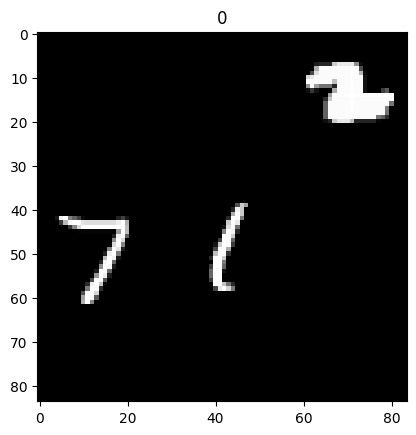

In [5]:

image, label = next(iter(train_ds))
print("Image shape: ", image.numpy().shape)
print("Label: ", label.numpy())

# convert label into 3digit number
label = label.numpy()
print("label shape: ", label.shape)
# get inidices of 1s in each digit
indices = np.where(label == 1)
# convert indices to digits
digits = [indices[0][i] % 10 for i in range(3)]

number = digits[0] * 100 + digits[1] * 10 + digits[2]
print("Number: ", number)
plt.title(number)

# show image
image = image.numpy()
image = np.reshape(image, (84, 84))
plt.imshow(image, cmap='gray')


In [6]:
for x, y in train_ds:
    print(x.shape)
    print(y.shape)
    break


(84, 84, 1)
(1, 30)


In [28]:
# copy model from first assignment
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Dropout, Resizing, ZeroPadding2D, LeakyReLU, BatchNormalization, MaxPooling2D

ann = keras.Sequential(
    [
        # Conv2D(filters=32, kernel_size=(2, 2), activation='relu',
        #        padding="Same", input_shape=(84, 84, 1)),

        #  Conv2D(filters=32, kernel_size=(2, 2), activation='relu',
        #         padding="Same"),
        #  MaxPool2D(pool_size=(2, 2)),
        #  Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
        #         padding="Same"),
        #  Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
        #         padding="Same"),
        #  MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        #  Dropout(0.25),
        Input(shape=(84, 84, 1)),
        ZeroPadding2D(padding=(2, 2)),
        Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
        LeakyReLU(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        BatchNormalization(),
        Flatten(),
        # Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(30, activation='softmax')
    ]
)


In [29]:
from keras.optimizers import RMSprop

# Compile the model
ann.build()
ann.compile(optimizer='adam',
            loss="categorical_crossentropy", metrics=["accuracy"])
ann.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_4 (ZeroPaddi  (None, 88, 88, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 84, 84, 32)        832       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 84, 84, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 42, 42, 32)       128       
 hNormalization)                                                 
                                                      

In [30]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 30  # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
history = ann.fit(train_ds,
                  batch_size=batch_size, epochs=epochs, validation_data=val_ds)


Epoch 1/30
  656/64000 [..............................] - ETA: 18:24 - loss: 0.0000e+00 - accuracy: 0.0000e+00

KeyboardInterrupt: 